# ISPR 2025 - Midterm 3 - Assignament 2 - Gianluca Panzani (550358)

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms

## Dataset class definition

Here are defined some utility methods and the Dataset class, which allows to iterate easily on the batches of the dataset.

The size of the images has been standardized to 128x128 during the loading.

Mean and standard deviation were computed over the training images in order to normalize the input data. This ensures that the input distribution is centered and scaled. The mean and standard deviation were calculated per channel (R,G,B) by averaging over all pixels in the dataset.

In [2]:
def get_img(img_dir: str, prefix: str, index: int, postfix: str, mask=False) -> Image:
    '''
    Get the image from the directory. The name of the image is composed as follows: "<img_dir><prefix>[<zeros>]<index><postfix>".
    The number of zeros is determined by the index.
    
    Parameters:
    - img_dir (str): directory where the images are stored.
    - prefix (str): prefix of the image name.
    - index (int): index of the image.
    - postfix (str): postfix of the image name.
    - mask (bool): is True if the image is a mask, False if the image is a normal image.

    Returns: the image as a PIL Image object.
    '''
    zeros = '00' if index < 10 else '0' if index < 100 else ''
    full_path = f'{img_dir}{prefix}{zeros}{index}{postfix}'
    if not mask:
        return Image.open(full_path).convert('RGB')
    return Image.open(full_path).convert('L')

def from_img_to_tensor(img: Image, resize_shape: tuple, mean=None, std=None) -> torch.Tensor:
    '''
    Convert the image to a tensor. Are applied normalization, if mean and std are provided, and resize.
    
    Parameters:
    - img (PIL.Image): image to be converted.
    - resize_shape (tuple): shape to resize the image to.
    - mean (list): mean values for normalization.
    - std (list): std values for normalization.

    Returns: the image as a tensor.
    '''
    if mean is not None and std is not None:
        if not (len(mean) == 3 and len(std) == 3):
            raise ValueError('The image has 3 channles. The parameters "mean" and "std" have to be lists with length equal to 3.')
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor(), # Scaling
            transforms.Normalize(mean, std) # Normalization
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor() # Scaling
        ])
    return transform(img)
    
def from_mask_to_tensor(img: Image, resize_shape: tuple) -> torch.Tensor:
    '''
    Convert the mask to a tensor and resize is applied.
    
    Parameters:
    - img (PIL.Image): image to be converted.
    - resize_shape (tuple): shape to resize the image to.
    
    Returns: the image as a tensor.
    '''
    img = img.resize(resize_shape, resample=Image.NEAREST)
    img_np = np.array(img)
    if img_np.max() > 1:
        img_np = (img_np > 127).astype(np.uint8)
    tensor = torch.from_numpy(img_np).float().unsqueeze(0)  # shape: [1, H, W]
    return tensor

def get_mean_and_std(images_dir: str, img_prefix: str, img_postfix: str, resize_shape: tuple):
    '''
    Compute the mean and the standard deviation of all the images in the directory. The name of the image is composed as follows:
    "<img_dir><prefix>[<zeros>]<index><postfix>". The number of zeros is determined by the index, which is incremented until the image is not found.
    
    Parameters:
    - images_dir (str): directory where the images are stored.
    - img_prefix (str): prefix of the image name.
    - img_postfix (str): postfix of the image name.
    - resize_shape (tuple): shape to resize the image to.
    
    Returns:
    - mean (list): the mean of the images.
    - std (list): the standard deviation of the images.
    '''
    mean = torch.zeros(3)
    std = torch.zeros(3)
    i = 0
    while True:
        i += 1
        try:
            image = get_img(img_dir=images_dir, prefix=img_prefix, index=i, postfix=img_postfix, mask=False)
        except:
            break
        img = from_img_to_tensor(img=image, resize_shape=resize_shape)
        mean += img.mean(dim=(1, 2)) # Mean computed on each channel (e.g. with RGB -> [meanR,meanG,meanB])
        std += img.std(dim=(1, 2)) # Std computed on each channel (e.g. with RGB -> [stdR,stdG,stdB])
    mean = (mean / (i-1)).tolist()
    std = (std / (i-1)).tolist()
    return mean, std



class HorseSegmentationDataset(Dataset):
    def __init__(self, images_dir, img_prefix, img_postfix, masks_dir, mask_prefix, mask_postfix, resize_shape=(128,128)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.img_postfix = img_postfix
        self.mask_postfix = mask_postfix
        self.resize_shape = resize_shape
        self.length = len(os.listdir(images_dir))
        mean, std = get_mean_and_std(
            images_dir=self.images_dir,
            img_prefix=self.img_prefix,
            img_postfix=self.img_postfix,
            resize_shape=self.resize_shape
        )
        self.mean = mean
        self.std = std

    def __getitem__(self, index):
        img = get_img(self.images_dir, self.img_prefix, index+1, self.img_postfix, mask=False)
        mask = get_img(self.masks_dir, self.mask_prefix, index+1, self.mask_postfix, mask=True)
        img_tensor = from_img_to_tensor(img, self.resize_shape, self.mean, self.std)
        mask_tensor = from_mask_to_tensor(mask, self.resize_shape)
        return img_tensor, mask_tensor
    
    def __len__(self):
        return self.length



# Creation of the dataset object
horse_dataset = HorseSegmentationDataset(
    images_dir='weizmann_horse_db/horse/',
    img_prefix='horse',
    img_postfix='.png',
    masks_dir='weizmann_horse_db/mask/',
    mask_prefix='horse',
    mask_postfix='.png',
    resize_shape=(128,128)
)

## Model class

In the following block, are implemented 2 classes: the ConvolutionalAE and the UNet.

Initially i have implemented the CAE architecture, but i have seen that results wasn't satisfiable and search better parameters was hard. In fact, with this architecture, i reached at most ~77% of IoU score. This is why i decided to implement a UNet too, which performed fastly better than the CAE. Both the implementations are dynamic, so that allowed me to use a Grid search to find the best combination of hyperparameters (which is described below).

To be more precise, i cited the CAE architecture for completeness in the explanation of my reasoning, but it's not used in the following code. The model selection is performed with the only use of the UNet class, just because the performances are considerably better with respect to the ConvolutionalAE architecture.


## Architecture

The implemented architecture is a U-Net-based convolutional NN designed for semantic segmentation. It consists of an encoder–decoder structure with skip connections.

The encoder is composed of a sequence of convolutional blocks, each followed by a downsampling operation via max pooling (in the forward pass). At the bottom of the "U" structure, there is the bottleneck block which doubles the number of channels. The decoder mirrors the encoder in reverse order: each stage begins with a transposed convolution for upsampling, followed by a convolutional block that reduces the number of channels. The final layer is a 1×1 convolution to map the features to a single-channel output with sigmoid activation function.

Each convolutional block has two convolutional layers and two activation functions (ReLU or LeakyReLU).

The max pooling is performed with a kernel size of 2 and a stride of 2, halving the spatial dimensions of the feature maps.

Skip connections are used to concatenate encoder features with decoder inputs at each corresponding resolution level. The interpolation is used during decoding (when the size of the skip connection "x_skip" is different to the size of the "x") to enforce the dimensions of the current image "x" to the size of the skip connection. The bilinear method was chosen for its effectiveness in 2D interpolation. It computes the value of each interpolated pixel as a weighted average of its four nearest neighbors.

The padding in each convolutional block is half the dimension of the kernel.

In [3]:
class ConvolutionalAE(nn.Module):
    def __init__(self, encoder_channels: list[int], decoder_channels: list[int], encoder_kernel_sizes: list[int], decoder_kernel_sizes: list[int],
                 encoder_strides: list[int], decoder_strides: list[int], output_padding: int):
        super(ConvolutionalAE, self).__init__()
        # Encoder architecture
        layers = []
        for i in range(len(encoder_channels)-1):
            k = encoder_kernel_sizes[i]
            s = encoder_strides[i]
            layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=k, stride=s, padding=k//2))
            layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)
        # Decoder architecture
        layers = []
        for i in range(len(decoder_channels)-2):
            k = decoder_kernel_sizes[i]
            s = decoder_strides[i]
            layers.append(nn.ConvTranspose2d(decoder_channels[i], decoder_channels[i+1], kernel_size=k, stride=s, padding=k//2, output_padding=output_padding))
            layers.append(nn.ReLU())
        layers.append(nn.ConvTranspose2d(decoder_channels[-2], decoder_channels[-1], kernel_size=decoder_kernel_sizes[-1], stride=decoder_strides[-1]))
        layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return x
    



class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128], kernel_size=3, activation='relu'):
        super(UNet, self).__init__()
        # Initializations
        self.kernel_size = kernel_size
        self.activation = activation
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        # Encoder
        for feature in features:
            self.encoders.append(self._convolutional_block(in_channels, feature))
            in_channels = feature
        # Bottleneck
        self.bottleneck = self._convolutional_block(features[-1], 2*features[-1])
        # Decoder
        in_channels = 2*features[-1]
        for feature in features[::-1]: # Scans the list reversed (step=-1)
            self.decoders.append(nn.ConvTranspose2d(in_channels, feature, kernel_size=2, stride=2))
            self.decoders.append(self._convolutional_block(2*feature, feature))
            in_channels = feature
        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        skip_connections = []
        for encoder in self.encoders:
            x = encoder(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.bottleneck(x)
        # Decoding
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.decoders), 2):
            block1_index = i
            block2_index = i+1
            x = self.decoders[block1_index](x) # Transposed Convolutional block
            x_skip = skip_connections[i//2]
            if x.shape != x_skip.shape: # Case of interpolation
                x = F.interpolate(x, size=x_skip.shape[2:]) # (A, B, H, W) -> (A, B, H', W')
            x = torch.cat((x_skip, x), dim=1)
            x = self.decoders[block2_index](x) # Convolutional block
        # Final convolution
        x = self.final_conv(x)
        return torch.sigmoid(x)

    def _convolutional_block(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, padding=self.kernel_size//2),
            self._get_activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, padding=self.kernel_size//2),
            self._get_activation(),
        ]
        return nn.Sequential(*layers)

    def _get_activation(self):
        if self.activation == 'relu':
            return nn.ReLU(inplace=True)
        elif self.activation == 'leaky_relu':
            return nn.LeakyReLU(inplace=True)
        else:
            raise ValueError(f'Unsupported activation: {self.activation}')

## Training method

The training method performs both the training and validation phases. During each epoch, it computes the loss on the training set, the loss on the validation set and the Intersection over Union (IoU) score.

IoU measures the overlap between the predicted mask and actual mask, and is commonly used as accuracy metric in segmentation tasks.

The early stopping is implemented to avoid overfitting and it's performed in two cases:
- when for "tolerance" consecutive epochs the following condition is satisfied: "the mean of the last k IoU scores of the current iteration" - "the mean of the best consecutive k IoU scores" < threshold,
- when the difference between the training loss and the validation loss is higher than 10%.

In [ ]:
def iou(preds: torch.Tensor, masks: torch.Tensor) -> float:
    '''
    Computes the Intersection over Union (IoU) score between the predicted masks and the actual masks.

    Parameters:
    - preds: the predicted masks (output of the model).
    - masks: the actual masks (ground truth).

    Returns:
    - iou_score: the IoU score.
    '''
    preds = (preds > 0.5).float()
    masks = (masks > 0.5).float()
    # Compute intersection and union
    intersection = (preds * masks).sum()
    union = ((preds + masks) > 0).float().sum()
    # Case of empty union (the predictions and the masks are empty, so equal)
    if union == 0:
        return 1.0
    iou_score = intersection / union
    return iou_score.item()



def train(model: nn.Module, tr_dataloader: DataLoader, vl_dataloader: DataLoader, optimizer, criterion, device, epochs, threshold, tolerance, verbose=1):
    '''
    Performs the training and the validation of the model.

    Parameters:
    - model: the model to train.
    - tr_dataloader: the training set.
    - vl_dataloader: the validation set.
    - optimizer: the optimizer to use.
    - criterion: the loss function to use.
    - device: the device to use (CPU or GPU).
    - epochs: the number of epochs.
    - threshold: the threshold to use for early stopping.
    - tolerance: the number of epochs of tolerance for early stopping.
    - verbose: the verbosity level (0 = no output, 1 = output every epoch).

    Returns:
    - tr_losses: the training losses list.
    - vl_losses: the validation losses list.
    - iou_scores: the IoU scores list.
    '''
    model.to(device)

    # Initializations
    k = 5
    patience = 0
    best_mean_iou_avg_score = 0
    tr_losses = []
    vl_losses = []
    iou_scores = []

    # Iterate on the epochs
    for epoch in range(epochs):

        # Training phase
        model.train()
        total_loss = 0.0
        for imgs, masks in tr_dataloader:
            imgs = imgs.to(device)          # Move images' tensors on GPU or CPU
            masks = masks.to(device)        # Move masks' tensors on GPU or CPU

            preds = model(imgs)             # Compute the predictions
            loss = criterion(preds, masks)  # Compute the loss
            optimizer.zero_grad()           # Reset the gradients
            loss.backward()                 # Perform backpropagation
            optimizer.step()                # Update model's parameters (based on gradients)

            total_loss += loss.item()       # Update total loss with the average loss on this batch

        tr_avg_loss = total_loss / len(tr_dataloader)
        tr_losses.append(tr_avg_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            total_iou = 0.0

            for imgs, masks in vl_dataloader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                preds = model(imgs)
                loss = criterion(preds, masks)

                total_loss += loss.item()
                total_iou += iou(preds, masks)

        vl_avg_loss = total_loss / len(vl_dataloader)
        vl_losses.append(vl_avg_loss)
        iou_avg_score = total_iou / len(vl_dataloader)
        iou_scores.append(iou_avg_score)

        # Print of the epoch result
        if verbose > 0:
            print(f'Epoch {epoch+1}/{epochs}: TR_loss={tr_avg_loss:.4f} - VL_loss={vl_avg_loss:.4f} - IoU={iou_avg_score:.4f}')
        
        # Early stopping (based on IoU score)
        current_mean_iou_avg_score = np.mean(iou_scores[-k:])
        if epoch > 2*k and (current_mean_iou_avg_score - best_mean_iou_avg_score < threshold or vl_avg_loss - tr_avg_loss > 0.1):
            patience += 1
        else:
            patience = 0
        if patience > tolerance:
            if verbose > 0:
                print(f'Early stopping at epoch {epoch+1}')
            break
        if best_mean_iou_avg_score < current_mean_iou_avg_score:
            best_mean_iou_avg_score = current_mean_iou_avg_score
    
    return tr_losses, vl_losses, iou_scores

## Grid search

The hyperparameters on which the Grid search is performed (for the UNet architecture) are:
- batch_size
- learning_rate
- epochs
- activation: the activation function to use.
- threshold: the threshold used in the condition of Early stopping.
- tolerance: the number of epochs of tolerence for the Early stopping.
- kernel_size: the dimension of the kernel.
- features: the number of features in the output for each convolutional block.

For example if features=[32,64,128] means that the decoder will has 3 layers and the number of channels that their outputs have are respectively 32, 64 and 128. The decoder is equal the encoder but reversed, as already described. The rest of the parameters are enough self-explanatory.

In [ ]:
# Space of the hyperparameters for ConvolutionalAE (not used)
'''
params_space = { # ignored parameters (not used in the model)
    'batch_size': [16, 32, 64],
    'learning_rate': [0.0001, 0.001],
    'epochs': [75],
    'threshold': [0.0001],
    'tolerance': [10],
    'architecture': [
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,3], 'encoder_strides': [2,2,2],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [3,3,3], 'decoder_strides': [2,2,2],
            'output_padding': 1
        },
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,5], 'encoder_strides': [2,2,1],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [5,3,3], 'decoder_strides': [1,2,2],
            'output_padding': 0
        },
        {
            'encoder_channels': [3,32,64,128], 'encoder_kernel_sizes': [3,3,3,3], 'encoder_strides': [2,2,2,1],
            'decoder_channels': [128,64,32,1], 'decoder_kernel_sizes': [3,3,3,3], 'decoder_strides': [1,2,2,2],
            'output_padding': 0
        },
        {
            'encoder_channels': [3,32,64,128,256], 'encoder_kernel_sizes': [3,3,3,3,3], 'encoder_strides': [2,2,2,2,1],
            'decoder_channels': [256,128,64,32,1], 'decoder_kernel_sizes': [3,3,3,3,3], 'decoder_strides': [1,2,2,2,2],
            'output_padding': 0
        }
    ]
}
'''

# Space of the hyperparameters for UNet
params_space = {
    'batch_size': [8, 16],
    'learning_rate': [0.0001, 0.001],
    'epochs': [150],
    'threshold': [0.0005],
    'tolerance': [7],
    'features': [[32, 64, 128], [32, 64, 128, 256]],
    'kernel_size': [3, 5],
    'activation': ['relu', 'leaky_relu'],
}

## Model selection

Given the dictionary of parameters lists, the code generates all the possible hyperparameters combinations. For each one is instantiated a model, which is trained.

The best model is chosen based on the mean of the last 3 IoU scores retured by the training function. The one with the maximum mean is selected for the testing phase.
The use of the mean is due to the fluctuation of the IoU score, in this way the evaluation is more consistent with respect to the simple comparison between the last IoU score of the two models.

For each parameters combination is created a model and, during training, are printed loss and IoU score on each epoch.

Hyperparameters [1/32]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.7149 - VL_loss=0.6933 - IoU=0.2328
Epoch 2/150: TR_loss=0.6247 - VL_loss=0.6046 - IoU=0.0000
Epoch 3/150: TR_loss=0.5831 - VL_loss=0.6008 - IoU=0.0000
Epoch 4/150: TR_loss=0.5522 - VL_loss=0.5431 - IoU=0.0000
Epoch 5/150: TR_loss=0.4629 - VL_loss=0.4411 - IoU=0.2149
Epoch 6/150: TR_loss=0.3901 - VL_loss=0.3847 - IoU=0.5034
Epoch 7/150: TR_loss=0.3586 - VL_loss=0.3668 - IoU=0.4150
Epoch 8/150: TR_loss=0.3299 - VL_loss=0.3260 - IoU=0.5134
Epoch 9/150: TR_loss=0.3125 - VL_loss=0.2919 - IoU=0.6067
Epoch 10/150: TR_loss=0.2953 - VL_loss=0.3015 - IoU=0.5761
Epoch 11/150: TR_loss=0.2748 - VL_loss=0.2585 - IoU=0.6749
Epoch 12/150: TR_loss=0.2636 - VL_loss=0.2569 - IoU=0.6891
Epoch 13/150: TR_loss=0.2543 - VL_loss=0.2668 - IoU=0.5941
Epoch 14/150: TR_loss=0.2423 - VL_loss=0.2746 - IoU=0.59

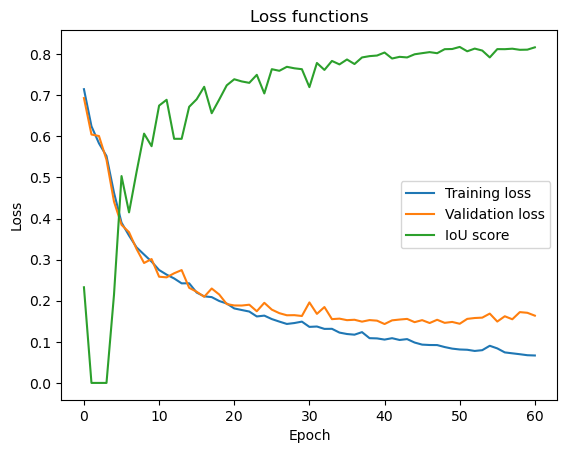


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8128464307103839
- Loss=0.16367717938763754
Hyperparameters [2/32]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6620 - VL_loss=0.6587 - IoU=0.0000
Epoch 2/150: TR_loss=0.6472 - VL_loss=0.6383 - IoU=0.0000
Epoch 3/150: TR_loss=0.6091 - VL_loss=0.6026 - IoU=0.0000
Epoch 4/150: TR_loss=0.5724 - VL_loss=0.5903 - IoU=0.0000
Epoch 5/150: TR_loss=0.5541 - VL_loss=0.5659 - IoU=0.0000
Epoch 6/150: TR_loss=0.5255 - VL_loss=0.5276 - IoU=0.0000
Epoch 7/150: TR_loss=0.4777 - VL_loss=0.4855 - IoU=0.0000
Epoch 8/150: TR_loss=0.4410 - VL_loss=0.4450 - IoU=0.0228
Epoch 9/150: TR_loss=0.3975 - VL_loss=0.4003 - IoU=0.3014
Epoch 10/150: TR_loss=0.3708 - VL_loss=0

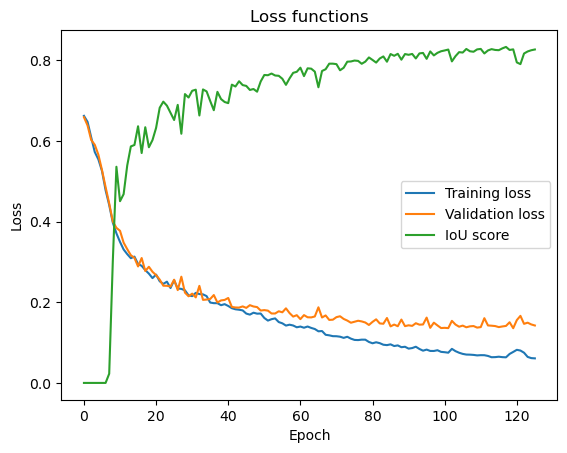


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8243115643660227
- Loss=0.14235511049628258
Hyperparameters [3/32]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6561 - VL_loss=0.5801 - IoU=0.0000
Epoch 2/150: TR_loss=0.5069 - VL_loss=0.4581 - IoU=0.3247
Epoch 3/150: TR_loss=0.4455 - VL_loss=0.4345 - IoU=0.3968
Epoch 4/150: TR_loss=0.4429 - VL_loss=0.4543 - IoU=0.3821
Epoch 5/150: TR_loss=0.4051 - VL_loss=0.4018 - IoU=0.4457
Epoch 6/150: TR_loss=0.3865 - VL_loss=0.3789 - IoU=0.3819
Epoch 7/150: TR_loss=0.3445 - VL_loss=0.3422 - IoU=0.5020
Epoch 8/150: TR_loss=0.3346 - VL_loss=0.3360 - IoU=0.5423
Epoch 9/150: TR_loss=0.2887 - VL_loss=0.2812 - IoU=0.6117
Epoch 10/150: TR_loss=0.2658 - VL_loss=0.

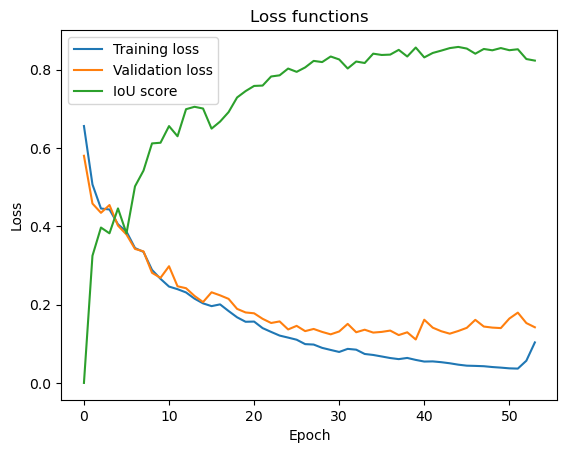


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8341819473675319
- Loss=0.14212658469166076
Hyperparameters [4/32]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6092 - VL_loss=0.5589 - IoU=0.0000
Epoch 2/150: TR_loss=0.4782 - VL_loss=0.4705 - IoU=0.3530
Epoch 3/150: TR_loss=0.4424 - VL_loss=0.4570 - IoU=0.4318
Epoch 4/150: TR_loss=0.4286 - VL_loss=0.4339 - IoU=0.2610
Epoch 5/150: TR_loss=0.3969 - VL_loss=0.4745 - IoU=0.1865
Epoch 6/150: TR_loss=0.4611 - VL_loss=0.4493 - IoU=0.3318
Epoch 7/150: TR_loss=0.4110 - VL_loss=0.4184 - IoU=0.4816
Epoch 8/150: TR_loss=0.3931 - VL_loss=0.4468 - IoU=0.2493
Epoch 9/150: TR_loss=0.3981 - VL_loss=0.3915 - IoU=0.5221
Epoch 10/150: TR_loss=0.3856 - VL_loss=0.4

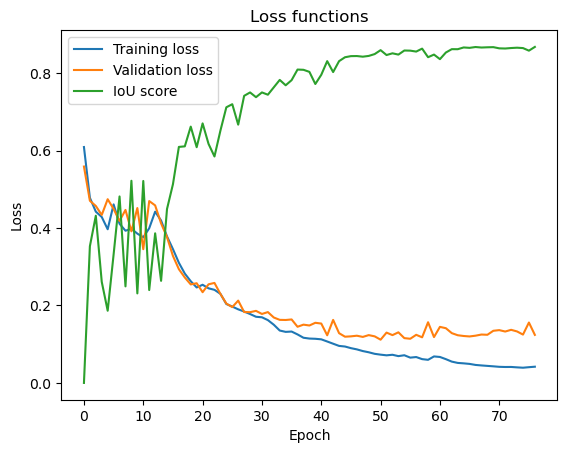


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8635909259319305
- Loss=0.1240497212857008
Hyperparameters [5/32]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6273 - VL_loss=0.5942 - IoU=0.0000
Epoch 2/150: TR_loss=0.5599 - VL_loss=0.5561 - IoU=0.0000
Epoch 3/150: TR_loss=0.4991 - VL_loss=0.4515 - IoU=0.0000
Epoch 4/150: TR_loss=0.4045 - VL_loss=0.3972 - IoU=0.4094
Epoch 5/150: TR_loss=0.3663 - VL_loss=0.3452 - IoU=0.6021
Epoch 6/150: TR_loss=0.3268 - VL_loss=0.3245 - IoU=0.5538
Epoch 7/150: TR_loss=0.3144 - VL_loss=0.3037 - IoU=0.6423
Epoch 8/150: TR_loss=0.2997 - VL_loss=0.2901 - IoU=0.6505
Epoch 9/150: TR_loss=0.2931 - VL_loss=0.2936 - IoU=0.6154
Epoch 10/150: TR_loss=0.2738 - VL_lo

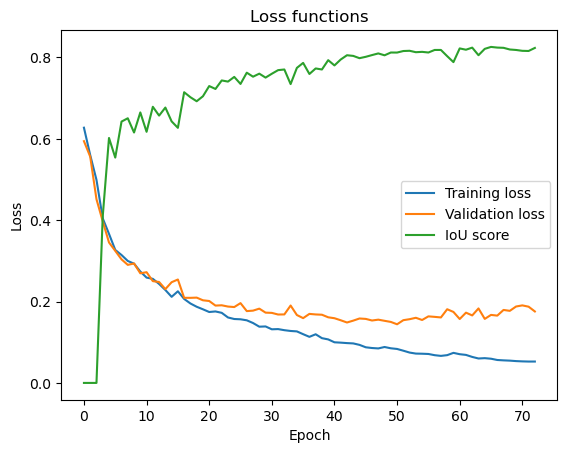


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8635909259319305
- Loss=0.1240497212857008
Hyperparameters [6/32]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.7005 - VL_loss=0.6952 - IoU=0.2719
Epoch 2/150: TR_loss=0.6851 - VL_loss=0.6720 - IoU=0.0001
Epoch 3/150: TR_loss=0.6289 - VL_loss=0.6161 - IoU=0.0000
Epoch 4/150: TR_loss=0.5845 - VL_loss=0.5984 - IoU=0.0000
Epoch 5/150: TR_loss=0.5613 - VL_loss=0.5801 - IoU=0.0090
Epoch 6/150: TR_loss=0.5366 - VL_loss=0.5507 - IoU=0.1260
Epoch 7/150: TR_loss=0.4835 - VL_loss=0.4767 - IoU=0.2286
Epoch 8/150: TR_loss=0.4027 - VL_loss=0.4489 - IoU=0.4162
Epoch 9/150: TR_loss=0.3822 - VL_loss=0.3859 - IoU=0.5176
Epoch 10/150: TR_loss=0.3464 - VL_l

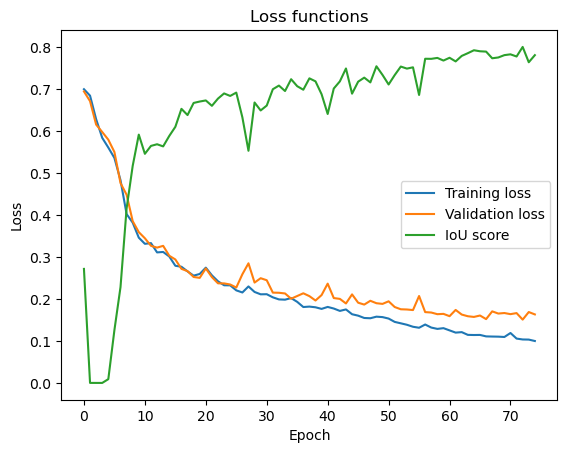


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8635909259319305
- Loss=0.1240497212857008
Hyperparameters [7/32]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.5810 - VL_loss=0.5141 - IoU=0.0000
Epoch 2/150: TR_loss=0.4580 - VL_loss=0.4651 - IoU=0.4008
Epoch 3/150: TR_loss=0.4350 - VL_loss=0.4227 - IoU=0.2469
Epoch 4/150: TR_loss=0.4386 - VL_loss=0.4099 - IoU=0.3684
Epoch 5/150: TR_loss=0.4044 - VL_loss=0.4506 - IoU=0.2385
Epoch 6/150: TR_loss=0.3645 - VL_loss=0.3859 - IoU=0.5505
Epoch 7/150: TR_loss=0.3830 - VL_loss=0.3721 - IoU=0.4179
Epoch 8/150: TR_loss=0.3517 - VL_loss=0.3643 - IoU=0.4486
Epoch 9/150: TR_loss=0.3273 - VL_loss=0.3068 - IoU=0.5350
Epoch 10/150: TR_loss=0.2929 - VL_los

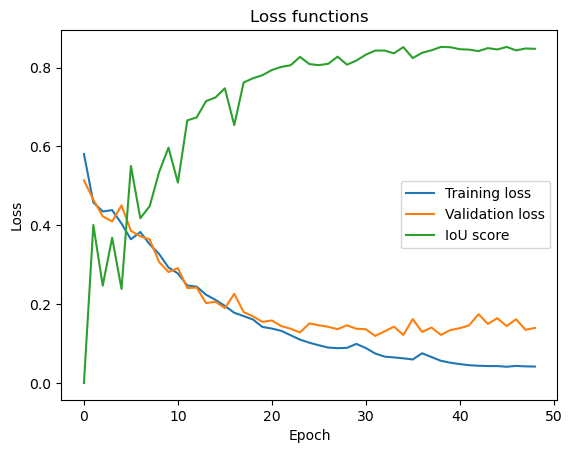


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8635909259319305
- Loss=0.1240497212857008
Hyperparameters [8/32]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6373 - VL_loss=0.5895 - IoU=0.0000
Epoch 2/150: TR_loss=0.5191 - VL_loss=0.5136 - IoU=0.3182
Epoch 3/150: TR_loss=0.4600 - VL_loss=0.4626 - IoU=0.3821
Epoch 4/150: TR_loss=0.4269 - VL_loss=0.4506 - IoU=0.2704
Epoch 5/150: TR_loss=0.4606 - VL_loss=0.4492 - IoU=0.3861
Epoch 6/150: TR_loss=0.4355 - VL_loss=0.4518 - IoU=0.3914
Epoch 7/150: TR_loss=0.4271 - VL_loss=0.4478 - IoU=0.2716
Epoch 8/150: TR_loss=0.4233 - VL_loss=0.4252 - IoU=0.3890
Epoch 9/150: TR_loss=0.3999 - VL_loss=0.4354 - IoU=0.2642
Epoch 10/150: TR_loss=0.3965 - VL_lo

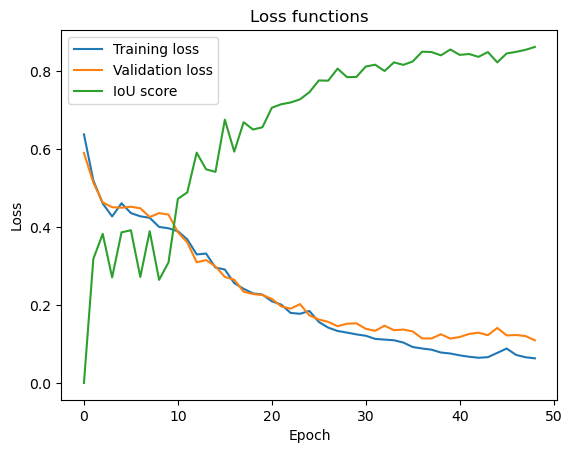


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8635909259319305
- Loss=0.1240497212857008
Hyperparameters [9/32]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6215 - VL_loss=0.5877 - IoU=0.0000
Epoch 2/150: TR_loss=0.5544 - VL_loss=0.5565 - IoU=0.0000
Epoch 3/150: TR_loss=0.4919 - VL_loss=0.4314 - IoU=0.0000
Epoch 4/150: TR_loss=0.3789 - VL_loss=0.3736 - IoU=0.4261
Epoch 5/150: TR_loss=0.3220 - VL_loss=0.3319 - IoU=0.6254
Epoch 6/150: TR_loss=0.3258 - VL_loss=0.3306 - IoU=0.5347
Epoch 7/150: TR_loss=0.2936 - VL_loss=0.2959 - IoU=0.6568
Epoch 8/150: TR_loss=0.2981 - VL_loss=0.2968 - IoU=0.5591
Epoch 9/150: TR_loss=0.2643 - VL_loss=0.2594 - IoU=0.6685
Epoch 10/150: TR_loss=0.2626 - VL_loss=0.2

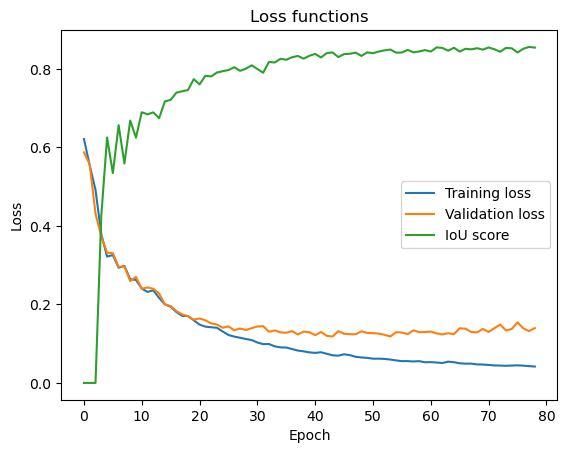


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8635909259319305
- Loss=0.1240497212857008
Hyperparameters [10/32]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6509 - VL_loss=0.6271 - IoU=0.0000
Epoch 2/150: TR_loss=0.5913 - VL_loss=0.5953 - IoU=0.0000
Epoch 3/150: TR_loss=0.5523 - VL_loss=0.5716 - IoU=0.0000
Epoch 4/150: TR_loss=0.5266 - VL_loss=0.5321 - IoU=0.0689
Epoch 5/150: TR_loss=0.4923 - VL_loss=0.5064 - IoU=0.2887
Epoch 6/150: TR_loss=0.4672 - VL_loss=0.4702 - IoU=0.3379
Epoch 7/150: TR_loss=0.4399 - VL_loss=0.4221 - IoU=0.5285
Epoch 8/150: TR_loss=0.3857 - VL_loss=0.3853 - IoU=0.5254
Epoch 9/150: TR_loss=0.3620 - VL_loss=0.3635 - IoU=0.5901
Epoch 10/150: TR_loss=0.3538 - VL_loss=0

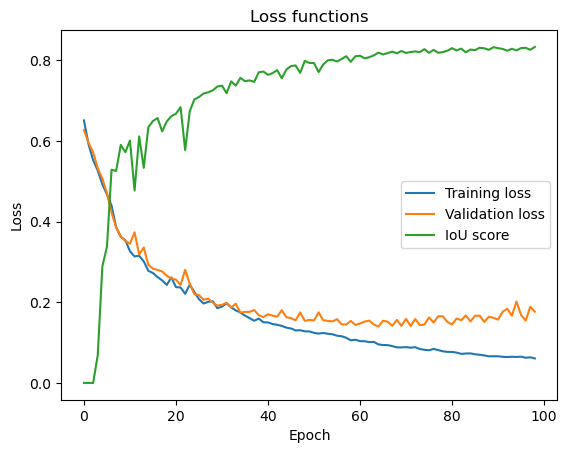


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8635909259319305
- Loss=0.1240497212857008
Hyperparameters [11/32]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6102 - VL_loss=0.5455 - IoU=0.0000
Epoch 2/150: TR_loss=0.4892 - VL_loss=0.4813 - IoU=0.0000
Epoch 3/150: TR_loss=0.4903 - VL_loss=0.4666 - IoU=0.0000
Epoch 4/150: TR_loss=0.4773 - VL_loss=0.5106 - IoU=0.3820
Epoch 5/150: TR_loss=0.4211 - VL_loss=0.3233 - IoU=0.6073
Epoch 6/150: TR_loss=0.3521 - VL_loss=0.3516 - IoU=0.5933
Epoch 7/150: TR_loss=0.3427 - VL_loss=0.3360 - IoU=0.5378
Epoch 8/150: TR_loss=0.2984 - VL_loss=0.2913 - IoU=0.6480
Epoch 9/150: TR_loss=0.2747 - VL_loss=0.2625 - IoU=0.6482
Epoch 10/150: TR_loss=0.2743 - VL_loss=0.2

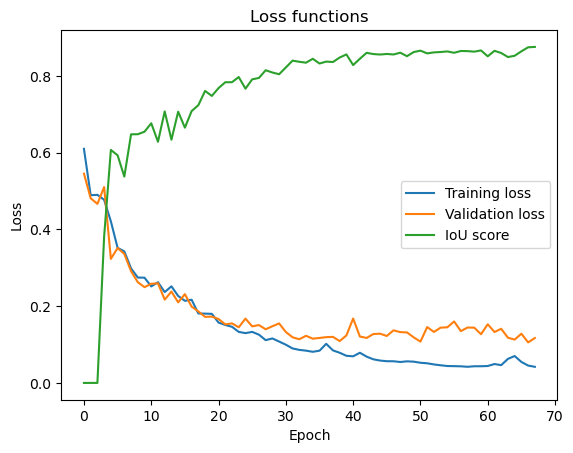


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [12/32]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.5598 - VL_loss=0.4842 - IoU=0.2736
Epoch 2/150: TR_loss=0.4702 - VL_loss=0.4663 - IoU=0.3720
Epoch 3/150: TR_loss=0.4292 - VL_loss=0.4651 - IoU=0.3529
Epoch 4/150: TR_loss=0.4180 - VL_loss=0.4532 - IoU=0.2849
Epoch 5/150: TR_loss=0.4251 - VL_loss=0.3711 - IoU=0.4741
Epoch 6/150: TR_loss=0.4069 - VL_loss=0.3846 - IoU=0.4106
Epoch 7/150: TR_loss=0.3508 - VL_loss=0.3889 - IoU=0.4507
Epoch 8/150: TR_loss=0.3188 - VL_loss=0.3493 - IoU=0.4441
Epoch 9/150: TR_loss=0.2937 - VL_loss=0.3154 - IoU=0.6485
Epoch 10/150: TR_loss=0.2611 - VL_loss=0.

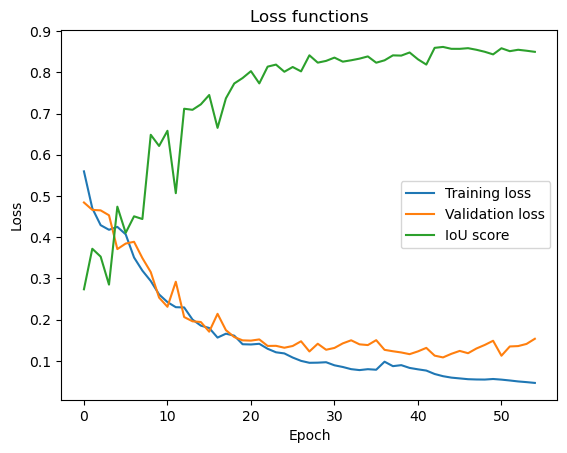


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [13/32]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6343 - VL_loss=0.5862 - IoU=0.0000
Epoch 2/150: TR_loss=0.5586 - VL_loss=0.5319 - IoU=0.0046
Epoch 3/150: TR_loss=0.4650 - VL_loss=0.4610 - IoU=0.4889
Epoch 4/150: TR_loss=0.4129 - VL_loss=0.3655 - IoU=0.5055
Epoch 5/150: TR_loss=0.3438 - VL_loss=0.3375 - IoU=0.5989
Epoch 6/150: TR_loss=0.3009 - VL_loss=0.3147 - IoU=0.5566
Epoch 7/150: TR_loss=0.2815 - VL_loss=0.3024 - IoU=0.5918
Epoch 8/150: TR_loss=0.2714 - VL_loss=0.2761 - IoU=0.6253
Epoch 9/150: TR_loss=0.2584 - VL_loss=0.2737 - IoU=0.6365
Epoch 10/150: TR_loss=0.2582 - VL_l

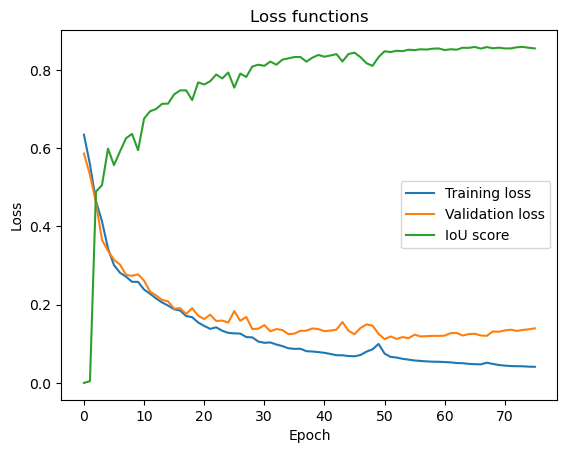


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [14/32]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6847 - VL_loss=0.6302 - IoU=0.0000
Epoch 2/150: TR_loss=0.5971 - VL_loss=0.6037 - IoU=0.0000
Epoch 3/150: TR_loss=0.5640 - VL_loss=0.5772 - IoU=0.0000
Epoch 4/150: TR_loss=0.5256 - VL_loss=0.5370 - IoU=0.3399
Epoch 5/150: TR_loss=0.4859 - VL_loss=0.4832 - IoU=0.4733
Epoch 6/150: TR_loss=0.4124 - VL_loss=0.3939 - IoU=0.5288
Epoch 7/150: TR_loss=0.3561 - VL_loss=0.3492 - IoU=0.5639
Epoch 8/150: TR_loss=0.3209 - VL_loss=0.3309 - IoU=0.5701
Epoch 9/150: TR_loss=0.3207 - VL_loss=0.3197 - IoU=0.6174
Epoch 10/150: TR_loss=0.2866 - VL_

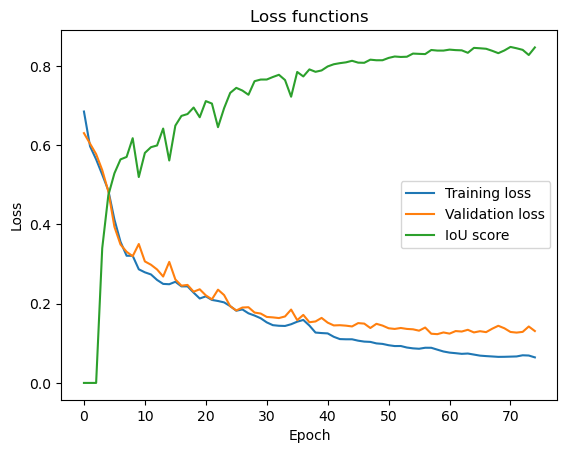


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [15/32]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.5218 - VL_loss=0.4761 - IoU=0.0695
Epoch 2/150: TR_loss=0.5250 - VL_loss=0.4424 - IoU=0.3626
Epoch 3/150: TR_loss=0.4430 - VL_loss=0.4348 - IoU=0.3544
Epoch 4/150: TR_loss=0.3904 - VL_loss=0.4068 - IoU=0.4926
Epoch 5/150: TR_loss=0.4485 - VL_loss=0.3740 - IoU=0.4611
Epoch 6/150: TR_loss=0.5198 - VL_loss=0.4549 - IoU=0.0000
Epoch 7/150: TR_loss=0.5515 - VL_loss=0.5200 - IoU=0.4235
Epoch 8/150: TR_loss=0.4636 - VL_loss=0.4056 - IoU=0.4647
Epoch 9/150: TR_loss=0.8248 - VL_loss=0.6326 - IoU=0.0000
Epoch 10/150: TR_loss=0.7329 - VL_lo

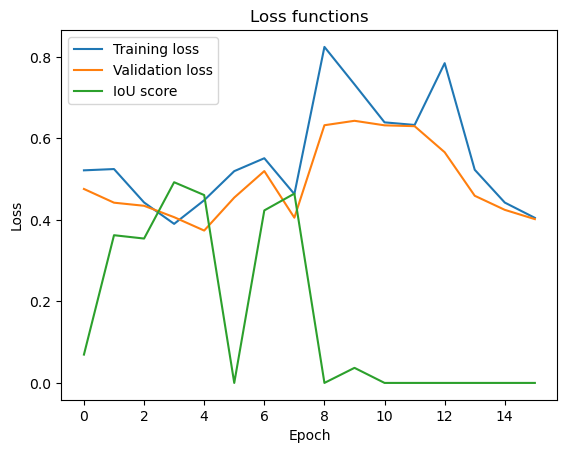


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [16/32]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.5739 - VL_loss=0.5324 - IoU=0.0000
Epoch 2/150: TR_loss=0.4868 - VL_loss=0.5274 - IoU=0.0000
Epoch 3/150: TR_loss=0.8060 - VL_loss=0.7084 - IoU=0.0000
Epoch 4/150: TR_loss=0.5096 - VL_loss=0.4802 - IoU=0.0858
Epoch 5/150: TR_loss=0.4704 - VL_loss=0.4590 - IoU=0.0000
Epoch 6/150: TR_loss=0.4375 - VL_loss=0.4235 - IoU=0.2079
Epoch 7/150: TR_loss=0.4326 - VL_loss=0.4702 - IoU=0.3762
Epoch 8/150: TR_loss=0.4462 - VL_loss=0.4611 - IoU=0.0569
Epoch 9/150: TR_loss=0.4497 - VL_loss=0.4298 - IoU=0.4362
Epoch 10/150: TR_loss=0.7623 - VL_l

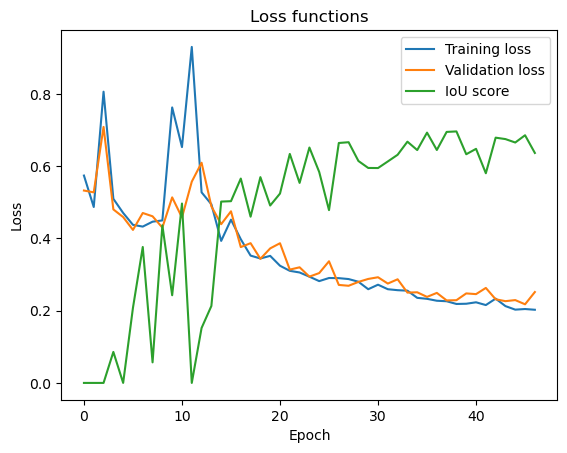


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [17/32]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6709 - VL_loss=0.6359 - IoU=0.0000
Epoch 2/150: TR_loss=0.5962 - VL_loss=0.5930 - IoU=0.0000
Epoch 3/150: TR_loss=0.5406 - VL_loss=0.4759 - IoU=0.0000
Epoch 4/150: TR_loss=0.4337 - VL_loss=0.4323 - IoU=0.2821
Epoch 5/150: TR_loss=0.4031 - VL_loss=0.4426 - IoU=0.4737
Epoch 6/150: TR_loss=0.3910 - VL_loss=0.3765 - IoU=0.5304
Epoch 7/150: TR_loss=0.3295 - VL_loss=0.3127 - IoU=0.5964
Epoch 8/150: TR_loss=0.3177 - VL_loss=0.3291 - IoU=0.5464
Epoch 9/150: TR_loss=0.2930 - VL_loss=0.2930 - IoU=0.6155
Epoch 10/150: TR_loss=0.2703 - VL_lo

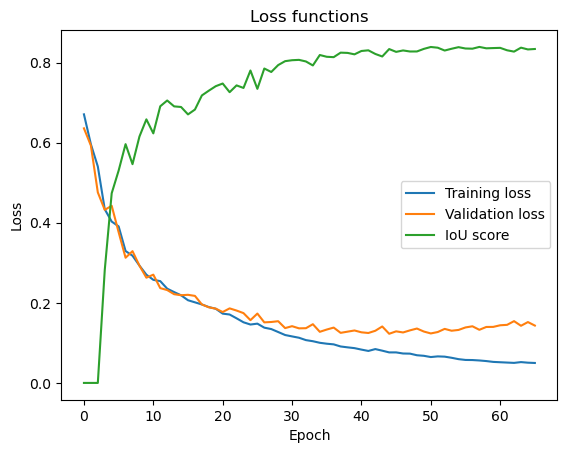


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [18/32]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.7025 - VL_loss=0.6950 - IoU=0.2376
Epoch 2/150: TR_loss=0.6755 - VL_loss=0.6486 - IoU=0.0000
Epoch 3/150: TR_loss=0.6053 - VL_loss=0.6052 - IoU=0.0000
Epoch 4/150: TR_loss=0.5709 - VL_loss=0.5900 - IoU=0.0000
Epoch 5/150: TR_loss=0.5392 - VL_loss=0.5347 - IoU=0.0000
Epoch 6/150: TR_loss=0.4707 - VL_loss=0.4679 - IoU=0.2064
Epoch 7/150: TR_loss=0.4255 - VL_loss=0.4548 - IoU=0.3284
Epoch 8/150: TR_loss=0.3919 - VL_loss=0.4161 - IoU=0.3753
Epoch 9/150: TR_loss=0.3586 - VL_loss=0.3837 - IoU=0.4829
Epoch 10/150: TR_loss=0.3407 - VL_l

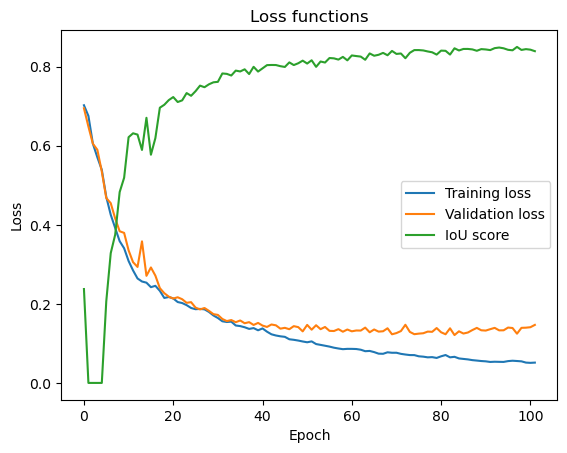


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [19/32]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6007 - VL_loss=0.5289 - IoU=0.0000
Epoch 2/150: TR_loss=0.4655 - VL_loss=0.4348 - IoU=0.3550
Epoch 3/150: TR_loss=0.4345 - VL_loss=0.5291 - IoU=0.4478
Epoch 4/150: TR_loss=0.4215 - VL_loss=0.3895 - IoU=0.4153
Epoch 5/150: TR_loss=0.3433 - VL_loss=0.3217 - IoU=0.5485
Epoch 6/150: TR_loss=0.3203 - VL_loss=0.3246 - IoU=0.5044
Epoch 7/150: TR_loss=0.3013 - VL_loss=0.3055 - IoU=0.5788
Epoch 8/150: TR_loss=0.2691 - VL_loss=0.2641 - IoU=0.6289
Epoch 9/150: TR_loss=0.2511 - VL_loss=0.2615 - IoU=0.6229
Epoch 10/150: TR_loss=0.2550 - VL_los

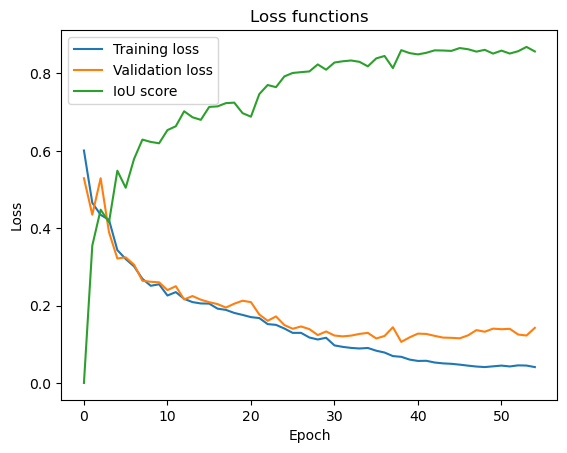


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [20/32]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6170 - VL_loss=0.5940 - IoU=0.0000
Epoch 2/150: TR_loss=0.5244 - VL_loss=0.5875 - IoU=0.3564
Epoch 3/150: TR_loss=0.5336 - VL_loss=0.5080 - IoU=0.0057
Epoch 4/150: TR_loss=0.4834 - VL_loss=0.4866 - IoU=0.0000
Epoch 5/150: TR_loss=0.4686 - VL_loss=0.4858 - IoU=0.2260
Epoch 6/150: TR_loss=0.4570 - VL_loss=0.4707 - IoU=0.3389
Epoch 7/150: TR_loss=0.4384 - VL_loss=0.4568 - IoU=0.2157
Epoch 8/150: TR_loss=0.4198 - VL_loss=0.4249 - IoU=0.4108
Epoch 9/150: TR_loss=0.4401 - VL_loss=0.4467 - IoU=0.4013
Epoch 10/150: TR_loss=0.4172 - VL_lo

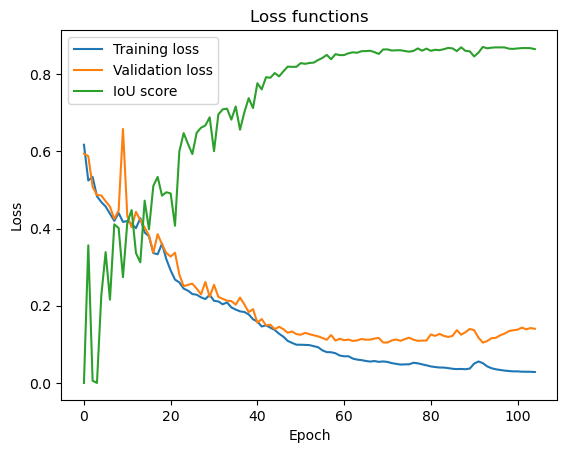


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [21/32]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6878 - VL_loss=0.6528 - IoU=0.0000
Epoch 2/150: TR_loss=0.6054 - VL_loss=0.5902 - IoU=0.0000
Epoch 3/150: TR_loss=0.4954 - VL_loss=0.4802 - IoU=0.4485
Epoch 4/150: TR_loss=0.4247 - VL_loss=0.4163 - IoU=0.4581
Epoch 5/150: TR_loss=0.3800 - VL_loss=0.3901 - IoU=0.4287
Epoch 6/150: TR_loss=0.3520 - VL_loss=0.3929 - IoU=0.4518
Epoch 7/150: TR_loss=0.3325 - VL_loss=0.3276 - IoU=0.5491
Epoch 8/150: TR_loss=0.3177 - VL_loss=0.3299 - IoU=0.5466
Epoch 9/150: TR_loss=0.3018 - VL_loss=0.3065 - IoU=0.5816
Epoch 10/150: TR_loss=0.2885 -

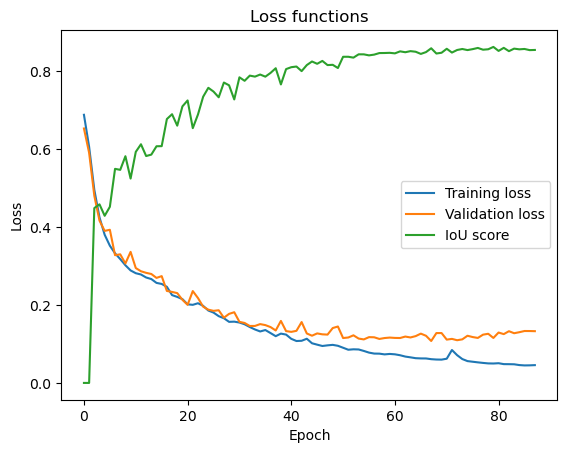


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [22/32]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6631 - VL_loss=0.6623 - IoU=0.0000
Epoch 2/150: TR_loss=0.6525 - VL_loss=0.6440 - IoU=0.0000
Epoch 3/150: TR_loss=0.6049 - VL_loss=0.5956 - IoU=0.0000
Epoch 4/150: TR_loss=0.5632 - VL_loss=0.5785 - IoU=0.0000
Epoch 5/150: TR_loss=0.5121 - VL_loss=0.5289 - IoU=0.0000
Epoch 6/150: TR_loss=0.4344 - VL_loss=0.4452 - IoU=0.1152
Epoch 7/150: TR_loss=0.3951 - VL_loss=0.3929 - IoU=0.5448
Epoch 8/150: TR_loss=0.3364 - VL_loss=0.3355 - IoU=0.6051
Epoch 9/150: TR_loss=0.3114 - VL_loss=0.3362 - IoU=0.5331
Epoch 10/150: TR_loss=0.2943 

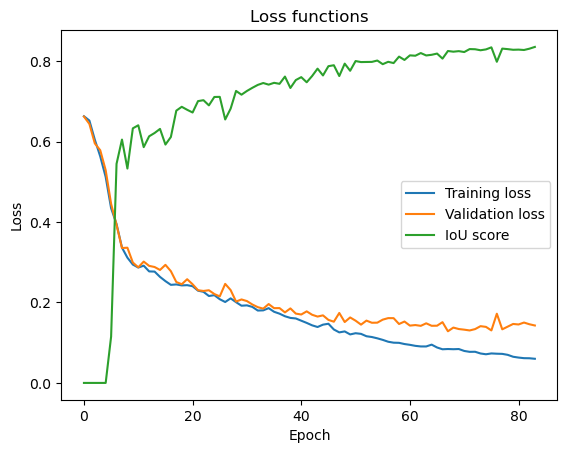


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [23/32]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6352 - VL_loss=0.5555 - IoU=0.0242
Epoch 2/150: TR_loss=0.4880 - VL_loss=0.4599 - IoU=0.4036
Epoch 3/150: TR_loss=0.4532 - VL_loss=0.4521 - IoU=0.3307
Epoch 4/150: TR_loss=0.4410 - VL_loss=0.4435 - IoU=0.4231
Epoch 5/150: TR_loss=0.4240 - VL_loss=0.4522 - IoU=0.2993
Epoch 6/150: TR_loss=0.4275 - VL_loss=0.4172 - IoU=0.3991
Epoch 7/150: TR_loss=0.4127 - VL_loss=0.4244 - IoU=0.3896
Epoch 8/150: TR_loss=0.4086 - VL_loss=0.4221 - IoU=0.3494
Epoch 9/150: TR_loss=0.4080 - VL_loss=0.4214 - IoU=0.4253
Epoch 10/150: TR_loss=0.4032 - 

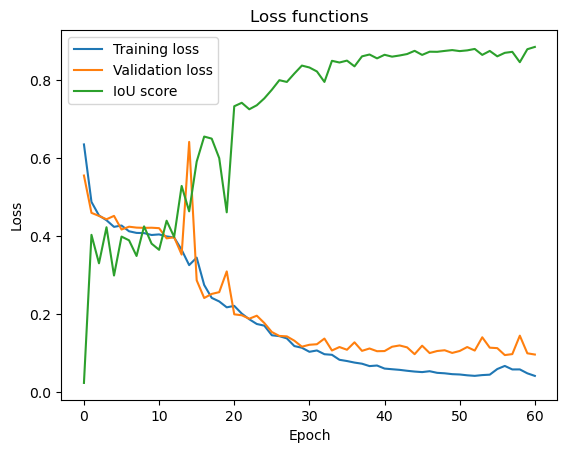


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8716255511556352
- Loss=0.11709915101528168
Hyperparameters [24/32]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6442 - VL_loss=0.5988 - IoU=0.0000
Epoch 2/150: TR_loss=0.5608 - VL_loss=0.5426 - IoU=0.0452
Epoch 3/150: TR_loss=0.4712 - VL_loss=0.4823 - IoU=0.2393
Epoch 4/150: TR_loss=0.4496 - VL_loss=0.4373 - IoU=0.3922
Epoch 5/150: TR_loss=0.4241 - VL_loss=0.4246 - IoU=0.4001
Epoch 6/150: TR_loss=0.4114 - VL_loss=0.4311 - IoU=0.3755
Epoch 7/150: TR_loss=0.4252 - VL_loss=0.4293 - IoU=0.4328
Epoch 8/150: TR_loss=0.4106 - VL_loss=0.4320 - IoU=0.3370
Epoch 9/150: TR_loss=0.3984 - VL_loss=0.4016 - IoU=0.4224
Epoch 10/150: TR_loss=0.3951 -

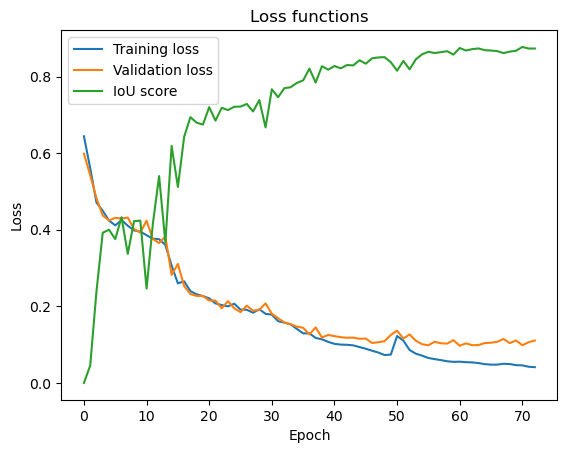


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8747764676809311
- Loss=0.11074032820761204
Hyperparameters [25/32]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6545 - VL_loss=0.6004 - IoU=0.0000
Epoch 2/150: TR_loss=0.5604 - VL_loss=0.5400 - IoU=0.0634
Epoch 3/150: TR_loss=0.4610 - VL_loss=0.4025 - IoU=0.5271
Epoch 4/150: TR_loss=0.3720 - VL_loss=0.3394 - IoU=0.5755
Epoch 5/150: TR_loss=0.3163 - VL_loss=0.3389 - IoU=0.5248
Epoch 6/150: TR_loss=0.2961 - VL_loss=0.2881 - IoU=0.6324
Epoch 7/150: TR_loss=0.2756 - VL_loss=0.2724 - IoU=0.6387
Epoch 8/150: TR_loss=0.2760 - VL_loss=0.2904 - IoU=0.5736
Epoch 9/150: TR_loss=0.2610 - VL_loss=0.2713 - IoU=0.6458
Epoch 10/150: TR_loss=0.

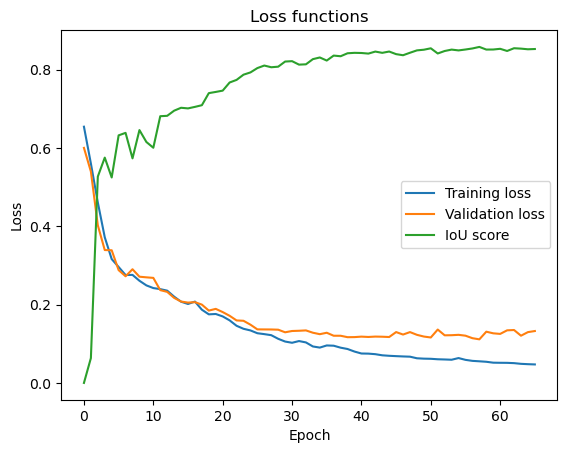


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8747764676809311
- Loss=0.11074032820761204
Hyperparameters [26/32]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6606 - VL_loss=0.6174 - IoU=0.0000
Epoch 2/150: TR_loss=0.5790 - VL_loss=0.5940 - IoU=0.0000
Epoch 3/150: TR_loss=0.5332 - VL_loss=0.5204 - IoU=0.0000
Epoch 4/150: TR_loss=0.4473 - VL_loss=0.4101 - IoU=0.5103
Epoch 5/150: TR_loss=0.3823 - VL_loss=0.4023 - IoU=0.4659
Epoch 6/150: TR_loss=0.3575 - VL_loss=0.3501 - IoU=0.5531
Epoch 7/150: TR_loss=0.3301 - VL_loss=0.3578 - IoU=0.4845
Epoch 8/150: TR_loss=0.3039 - VL_loss=0.3218 - IoU=0.5435
Epoch 9/150: TR_loss=0.2913 - VL_loss=0.2917 - IoU=0.6003
Epoch 10/150: TR_loss=0

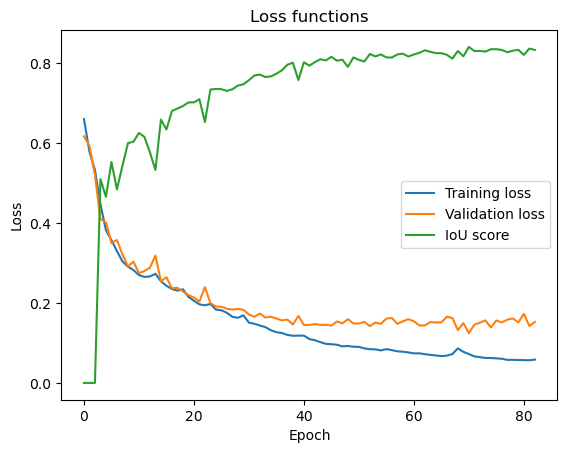


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8747764676809311
- Loss=0.11074032820761204
Hyperparameters [27/32]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.5571 - VL_loss=0.5117 - IoU=0.0265
Epoch 2/150: TR_loss=0.5012 - VL_loss=0.4870 - IoU=0.0000
Epoch 3/150: TR_loss=0.4393 - VL_loss=0.4725 - IoU=0.3962
Epoch 4/150: TR_loss=0.4253 - VL_loss=0.4100 - IoU=0.4484
Epoch 5/150: TR_loss=0.4113 - VL_loss=0.4031 - IoU=0.4320
Epoch 6/150: TR_loss=0.3673 - VL_loss=0.4200 - IoU=0.3699
Epoch 7/150: TR_loss=0.4149 - VL_loss=0.3762 - IoU=0.4730
Epoch 8/150: TR_loss=0.3374 - VL_loss=0.3460 - IoU=0.4335
Epoch 9/150: TR_loss=0.2830 - VL_loss=0.2647 - IoU=0.6464
Epoch 10/150: TR_loss=0.2

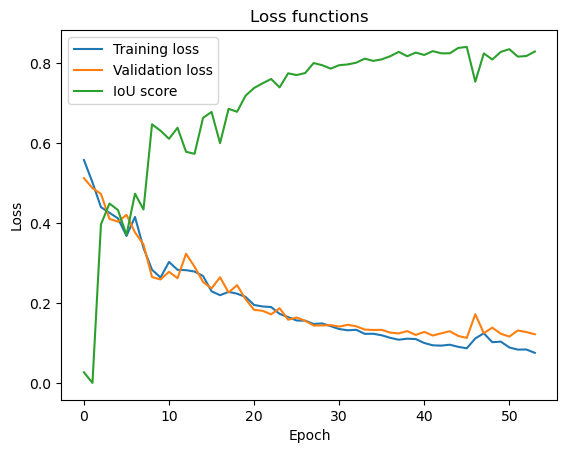


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8747764676809311
- Loss=0.11074032820761204
Hyperparameters [28/32]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=1.3751 - VL_loss=0.5915 - IoU=0.0000
Epoch 2/150: TR_loss=0.5480 - VL_loss=0.5261 - IoU=0.1794
Epoch 3/150: TR_loss=0.4584 - VL_loss=0.3868 - IoU=0.4694
Epoch 4/150: TR_loss=0.4420 - VL_loss=0.4125 - IoU=0.3328
Epoch 5/150: TR_loss=0.4487 - VL_loss=0.4506 - IoU=0.3780
Epoch 6/150: TR_loss=0.4128 - VL_loss=0.3697 - IoU=0.4894
Epoch 7/150: TR_loss=0.3632 - VL_loss=0.4265 - IoU=0.4037
Epoch 8/150: TR_loss=0.3019 - VL_loss=0.2955 - IoU=0.6207
Epoch 9/150: TR_loss=0.2735 - VL_loss=0.2883 - IoU=0.6563
Epoch 10/150: TR_loss=0.

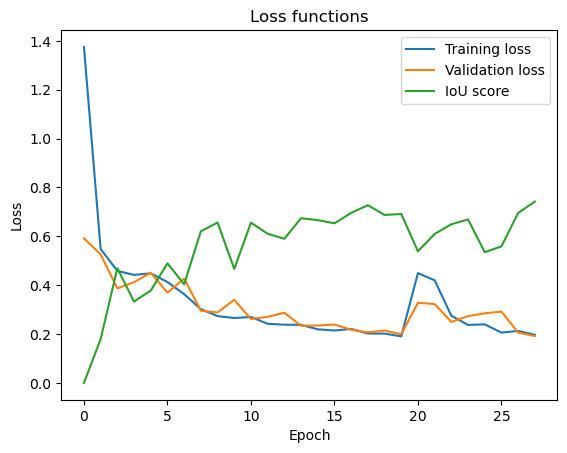


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8747764676809311
- Loss=0.11074032820761204
Hyperparameters [29/32]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6238 - VL_loss=0.5907 - IoU=0.0000
Epoch 2/150: TR_loss=0.5646 - VL_loss=0.5350 - IoU=0.1151
Epoch 3/150: TR_loss=0.4775 - VL_loss=0.4328 - IoU=0.5213
Epoch 4/150: TR_loss=0.3865 - VL_loss=0.3491 - IoU=0.5598
Epoch 5/150: TR_loss=0.3275 - VL_loss=0.3068 - IoU=0.6076
Epoch 6/150: TR_loss=0.3062 - VL_loss=0.2978 - IoU=0.6198
Epoch 7/150: TR_loss=0.2799 - VL_loss=0.2877 - IoU=0.5766
Epoch 8/150: TR_loss=0.2720 - VL_loss=0.3000 - IoU=0.5125
Epoch 9/150: TR_loss=0.2547 - VL_loss=0.2972 - IoU=0.5357
Epoch 10/150: TR_l

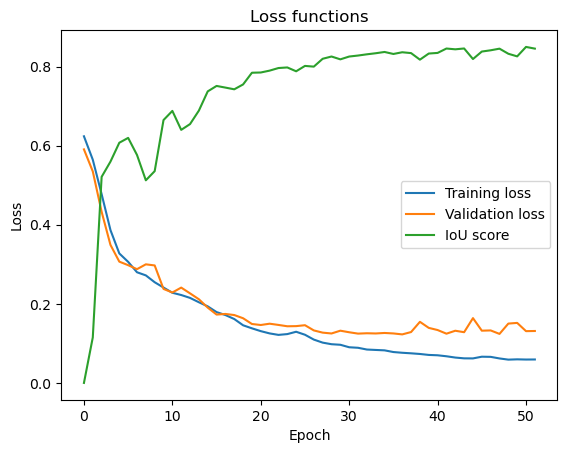


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8747764676809311
- Loss=0.11074032820761204
Hyperparameters [30/32]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6528 - VL_loss=0.6252 - IoU=0.0000
Epoch 2/150: TR_loss=0.5830 - VL_loss=0.5887 - IoU=0.0000
Epoch 3/150: TR_loss=0.5302 - VL_loss=0.5415 - IoU=0.0793
Epoch 4/150: TR_loss=0.4461 - VL_loss=0.4228 - IoU=0.5167
Epoch 5/150: TR_loss=0.3778 - VL_loss=0.3693 - IoU=0.5633
Epoch 6/150: TR_loss=0.3346 - VL_loss=0.3478 - IoU=0.5881
Epoch 7/150: TR_loss=0.3136 - VL_loss=0.3272 - IoU=0.5747
Epoch 8/150: TR_loss=0.3032 - VL_loss=0.3114 - IoU=0.5647
Epoch 9/150: TR_loss=0.2931 - VL_loss=0.2981 - IoU=0.6276
Epoch 10/150: TR_

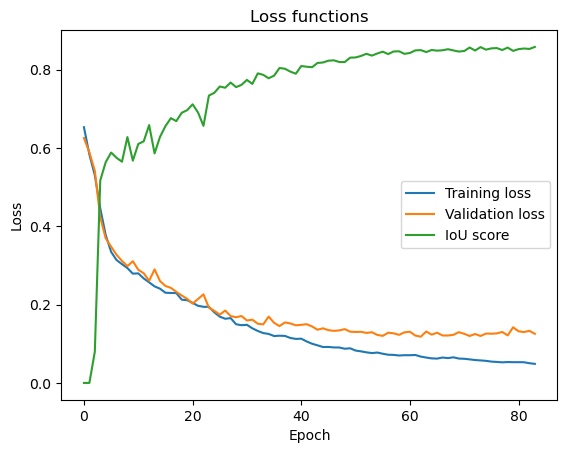


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8747764676809311
- Loss=0.11074032820761204
Hyperparameters [31/32]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.5286 - VL_loss=0.5169 - IoU=0.2735
Epoch 2/150: TR_loss=0.5045 - VL_loss=0.4383 - IoU=0.3305
Epoch 3/150: TR_loss=0.6982 - VL_loss=0.5080 - IoU=0.0000
Epoch 4/150: TR_loss=0.4490 - VL_loss=0.4191 - IoU=0.0000
Epoch 5/150: TR_loss=0.3891 - VL_loss=0.3611 - IoU=0.5855
Epoch 6/150: TR_loss=0.3649 - VL_loss=0.3877 - IoU=0.4465
Epoch 7/150: TR_loss=0.3140 - VL_loss=0.3064 - IoU=0.6323
Epoch 8/150: TR_loss=0.2833 - VL_loss=0.2631 - IoU=0.6500
Epoch 9/150: TR_loss=0.2545 - VL_loss=0.2906 - IoU=0.5778
Epoch 10/150: TR_lo

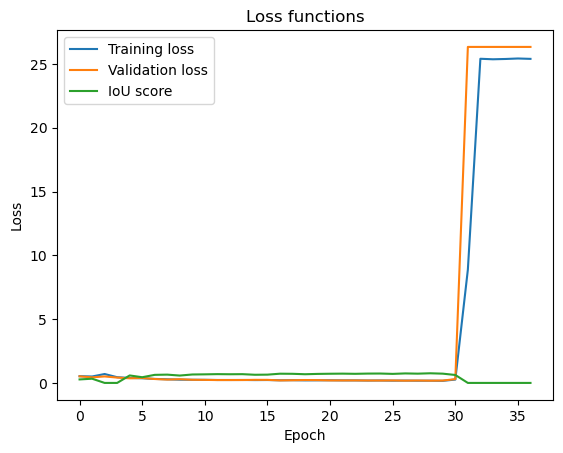


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8747764676809311
- Loss=0.11074032820761204
Hyperparameters [32/32]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.7086 - VL_loss=0.6491 - IoU=0.3276
Epoch 2/150: TR_loss=1.1328 - VL_loss=0.6039 - IoU=0.0003
Epoch 3/150: TR_loss=0.6877 - VL_loss=0.5735 - IoU=0.0000
Epoch 4/150: TR_loss=0.7097 - VL_loss=0.7349 - IoU=0.2317
Epoch 5/150: TR_loss=0.7626 - VL_loss=0.6292 - IoU=0.3445
Epoch 6/150: TR_loss=0.6712 - VL_loss=0.6797 - IoU=0.0001
Epoch 7/150: TR_loss=0.8729 - VL_loss=0.7118 - IoU=0.2704
Epoch 8/150: TR_loss=0.6971 - VL_loss=0.6020 - IoU=0.0000
Epoch 9/150: TR_loss=0.5526 - VL_loss=0.5404 - IoU=0.0184
Epoch 10/150: TR_l

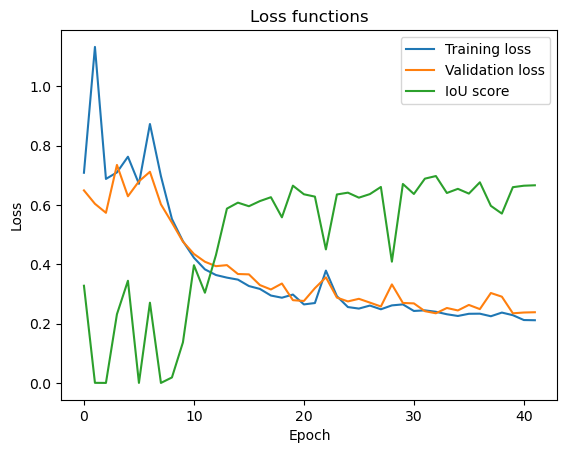


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8747764676809311
- Loss=0.11074032820761204


In [6]:
def get_params_combinations(params: dict) -> list[dict]:
    '''
    Creates and saves into the class instance a list with all the possible combinations of parameters \
    in the dictionary "params".

    Parameters:
    - params: dictionary with the parameters as associations <key:values> (with: key=parameter_name,
    values=possible_values_list).

    Returns:
    A list of dictionaries such that each one represents a combination of parameters (1 combination = 1 dictionary).
    '''
    params_index_dict = {}
    params_combinations = []
    for key in params.keys():
        params_index_dict[key] = 0 # current_index for that key
    while sum([index+1 for _, index in params_index_dict.items()]) != sum(len(val_list) for _, val_list in params.items()):
        params_i = {}
        for key, i in params_index_dict.items():
            params_i[key] = params[key][i]
        params_combinations.append(params_i)
        for key in params_index_dict.keys():
            params_index_dict[key] += 1
            if params_index_dict[key] < len(params[key]):
                break
            params_index_dict[key] = 0
    params_i = {}
    for key, i in params_index_dict.items():
        params_i[key] = params[key][i]
    params_combinations.append(params_i)
    return params_combinations


def show_plots(values_list: list[list], labels: list[str]):
    '''
    Shows the plots of the values in the list "values_list". Each list in "values_list" is plotted with
    the corresponding label in "labels".

    Parameters:
    - values_list: list of lists with the values to plot.
    - labels: list of labels for each plot.
    '''
    for i, values in enumerate(values_list):
        plt.plot(values, label=labels[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss functions')
    plt.show()


# Iterates on each parameters combination obtained from the parameters space
tr_dataset, vl_dataset, ts_dataset = random_split(horse_dataset, [0.70,0.15,0.15])
params_list = get_params_combinations(params_space)
model_i = None
best_model_obj = {'iou_scores': [0]}
for i, params in enumerate(params_list):
    print(f'Hyperparameters [{i+1}/{len(params_list)}]: {params}')

    # Datasets initializations
    tr_loader = DataLoader(tr_dataset, batch_size=params['batch_size'], shuffle=True)
    vl_loader = DataLoader(vl_dataset, batch_size=params['batch_size'], shuffle=False)

    # Create the model
    #model = ConvolutionalAE(**params['architecture'])
    model = UNet(kernel_size=params['kernel_size'], features=params['features'], activation=params['activation'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = torch.nn.BCELoss()

    # Training phase
    tr_losses, vl_losses, iou_scores = train(
        model,
        tr_dataloader=tr_loader,
        vl_dataloader=vl_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        epochs=params['epochs'],
        threshold=params['threshold'],
        tolerance=params['tolerance'],
        verbose=2
    )

    # Save the model and the parameters
    model_i = {
        'model': model,
        'params': params,
        'tr_losses': tr_losses,
        'vl_losses': vl_losses,
        'iou_scores': iou_scores
    }

    # Shows the Loss plots
    show_plots(
        values_list=[tr_losses,vl_losses,iou_scores],
        labels=['Training loss','Validation loss','IoU score']
    )

    # Save the model if is the best one (based on the highest mean of the last 3 IoU score)
    mean_iou_best_score = np.mean(best_model_obj['iou_scores'][-3:])
    mean_iou_score = np.mean(iou_scores[-3:])
    if mean_iou_best_score < mean_iou_score:
        best_model_obj = model_i
    print(f'\nBest model:\n- Hyperparameters={best_model_obj["params"]}\n- IoU score={np.mean(best_model_obj["iou_scores"][-3:])}\n- Loss={best_model_obj["vl_losses"][-1]}')

## Model evaluation

The following code evaluates the best model chosen in the Model selection.

The "evaluate" method shows the predicted masks for the first 10 images of the Test set and returns the average of the IoU score and the average of the loss.  
The denormalization is applied to the images before show them.

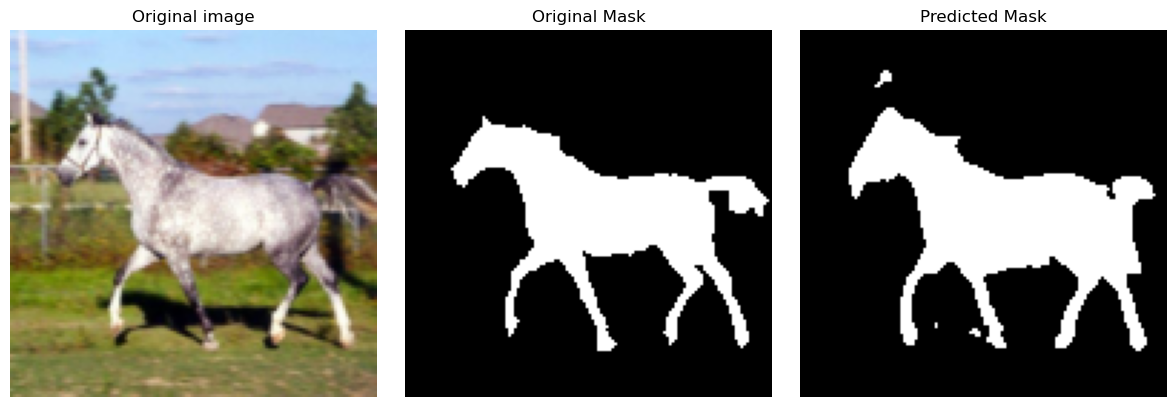

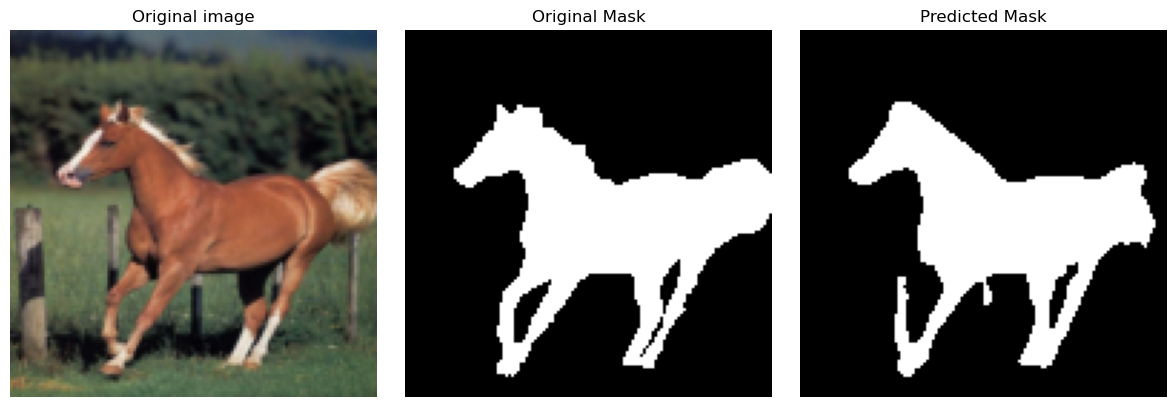

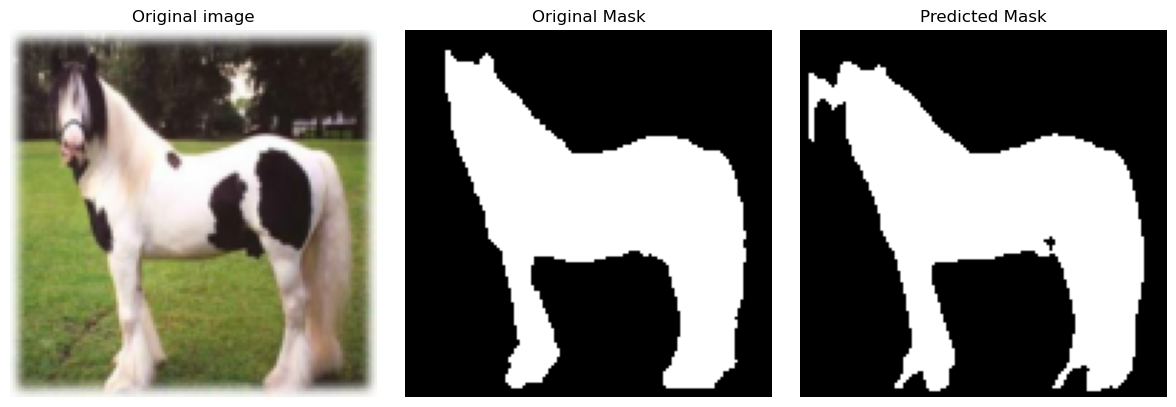

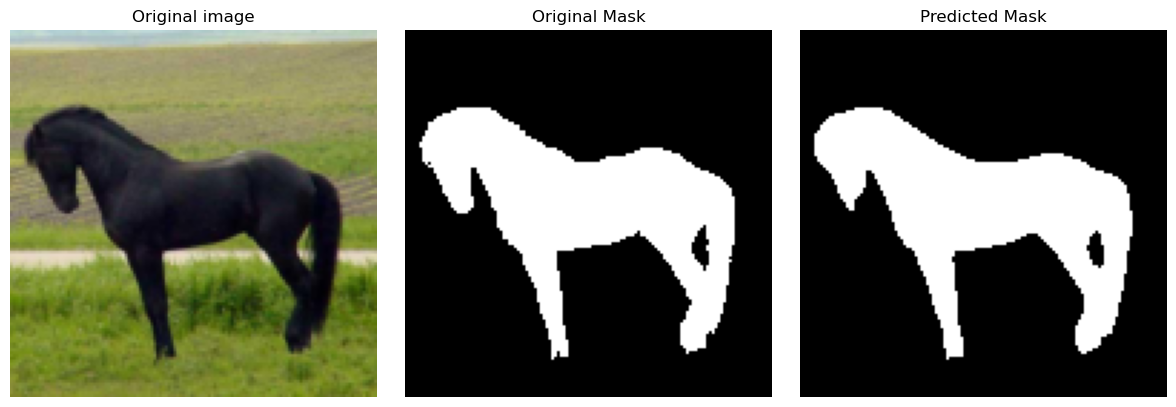

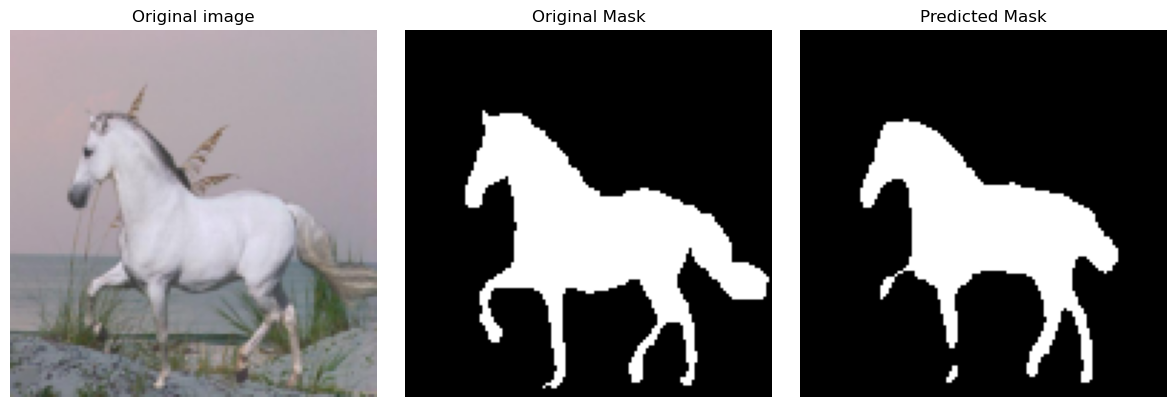

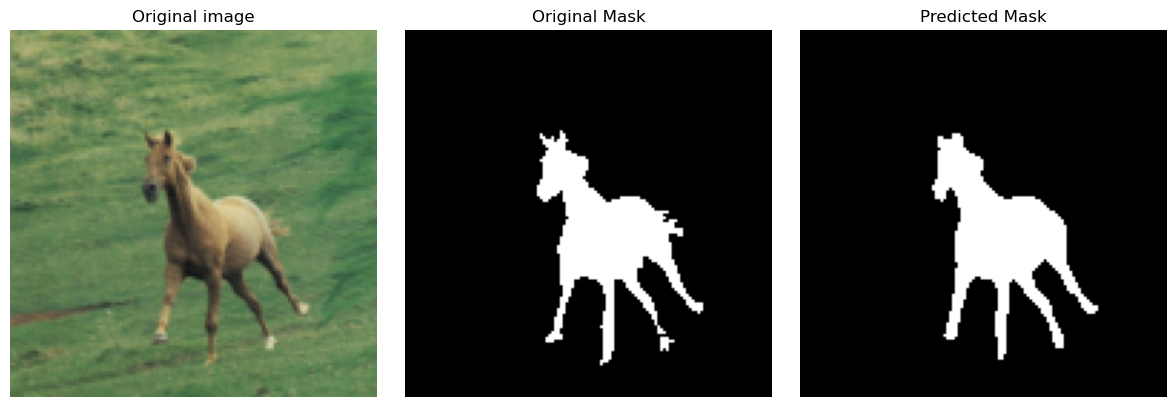

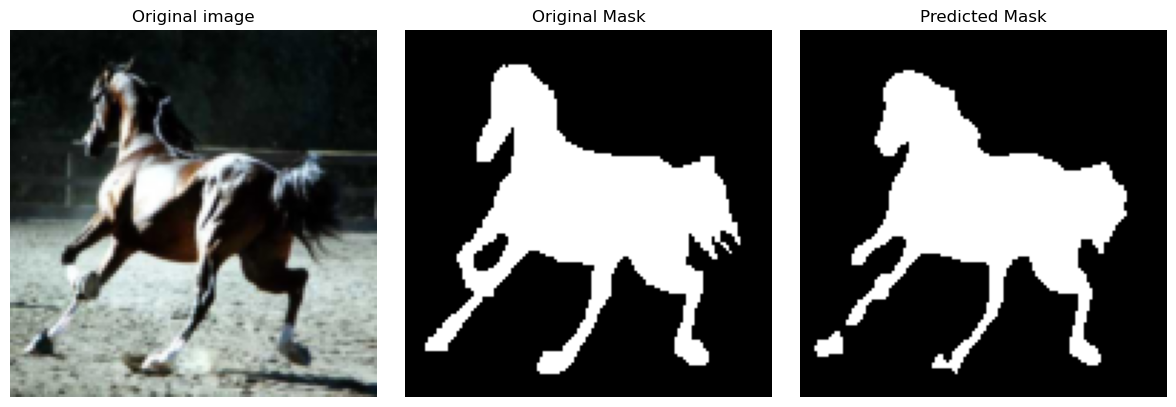

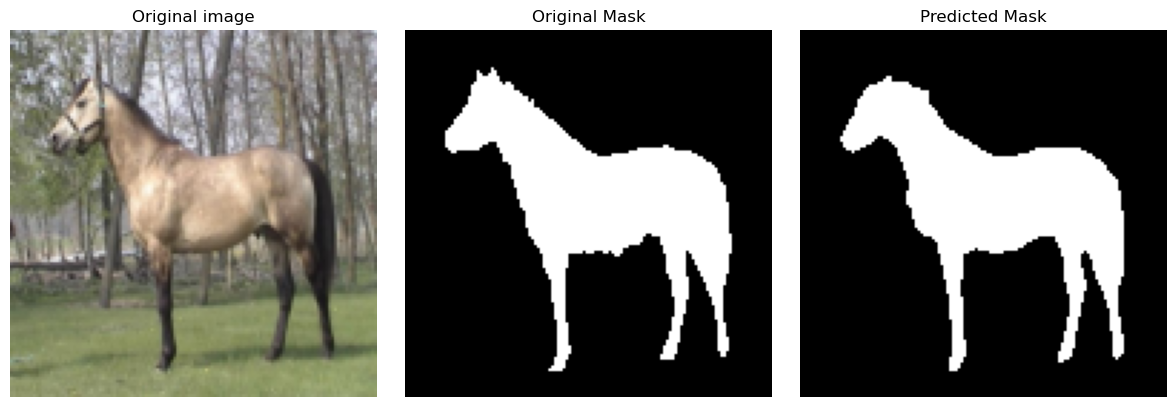

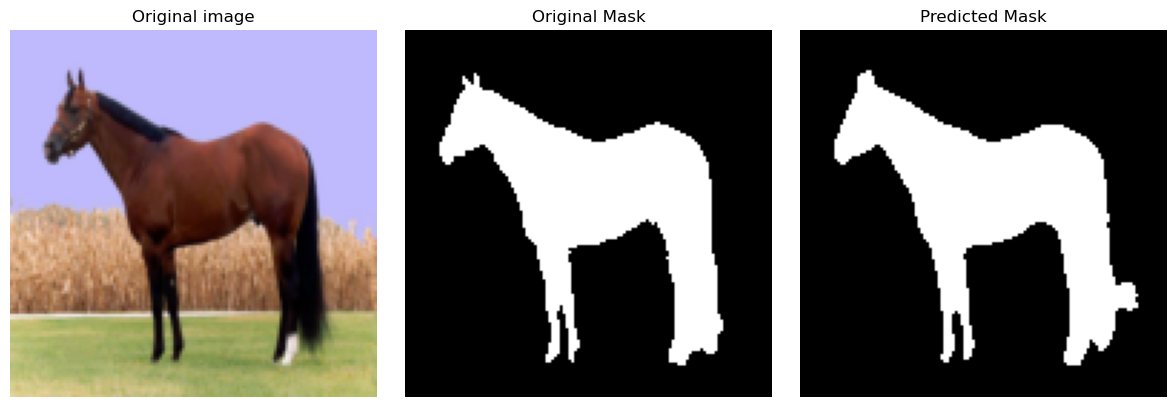

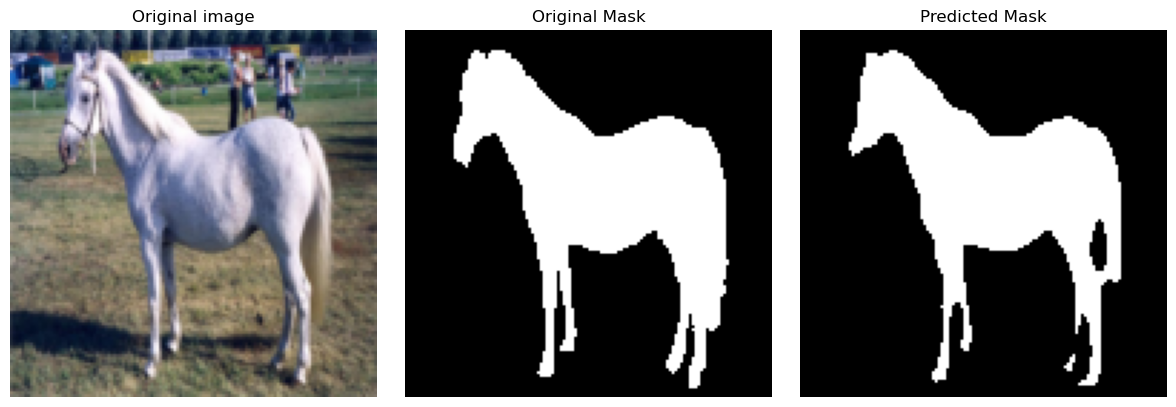

Best model parameters: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Test Loss: 0.1376155074685812
Test IoU score: 0.8642400801181793


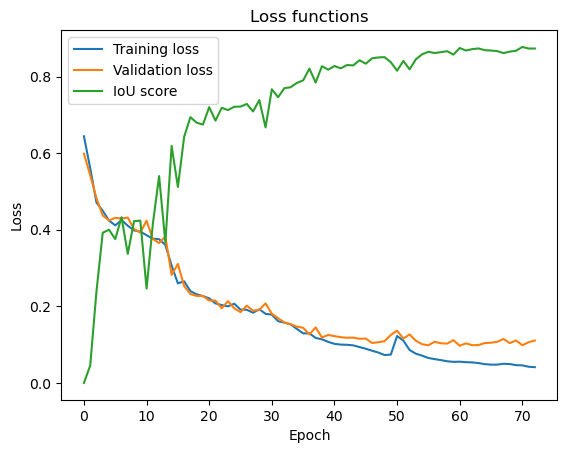

In [8]:
def show_prediction_plot(img: torch.Tensor, mask: torch.Tensor, pred: torch.Tensor):
    '''
    Shows the original image, the original mask and the predicted mask passed as parameters.

    Parameters:
    - img (torch.Tensor): the original image.
    - mask (torch.Tensor): the original mask.
    - pred (torch.Tensor): the predicted mask.
    '''
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].set_title('Original image')
    axs[0].axis('off')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Original Mask')
    axs[1].axis('off')
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()



def denormalize(img: torch.Tensor, dataset: Dataset) -> torch.Tensor:
    '''
    Denormalizes the image passed as parameter based on the mean and standard deviation of the dataset.
    
    Parameters:
    - img (torch.Tensor): the image to denormalize.
    - dataset (Dataset): the dataset of the image from which the mean and std are taken.
    '''
    mean, std = dataset.mean, dataset.std
    for tensor, m, s in zip(img, mean, std):
        tensor.mul_(s).add_(m)
    return img



def evaluate(model: nn.Module, ts_dataloader: DataLoader, criterion, device, n_imgs_to_show=10):
    '''
    Test the model on the test set. The model is evaluated using the IoU score.

    Parameters:
    - model (nn.Module): the model to evaluate.
    - ts_dataloader (DataLoader): the test set.
    - criterion: the loss function to use.
    - device: the device to use (CPU or GPU).
    - n_imgs_to_show: the number of images of which show the predictions.

    Returns:
    - iou_avg_score: the average IoU score.
    - avg_loss: the average loss.
    '''
    model.eval()
    model.to(device)

    # Initializations
    total_loss = 0.0
    total_iou = 0.0
    shown = 0

    with torch.no_grad():
        for imgs, masks in ts_dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Compute the predictions and the loss
            preds = model(imgs)
            loss = criterion(preds, masks)
            total_loss += loss.item()

            # Binarization of the predictions
            preds = (preds > 0.5).float()

            # Case of plot of the images
            if shown < n_imgs_to_show:
                # Matplotlib can't handle GPU tensors (so we need to move them to CPU)
                imgs_cpu = imgs.cpu()
                masks_cpu = masks.cpu()
                preds_cpu = preds.cpu()
                # Plot the images
                for img, mask, pred in zip(imgs_cpu, masks_cpu, preds_cpu):
                    mask = (mask > 0.5).float()
                    pred = (pred > 0.5).float()
                    if shown == n_imgs_to_show:
                        break
                    img = denormalize(img, horse_dataset)
                    show_prediction_plot(img.permute(1,2,0), mask[0], pred[0])
                    shown += 1

            # Compute the number of correct pixels predicted
            total_iou += iou(preds, masks)

    # Accuracy and average loss
    iou_avg_score = total_iou / len(ts_dataloader)
    avg_loss = total_loss / len(ts_dataloader)
    return iou_avg_score, avg_loss



# Create the test dataloader
ts_loader = DataLoader(ts_dataset, batch_size=best_model_obj['params']['batch_size'], shuffle=False)

# Evaluation phase
iou_score, avg_loss = evaluate(
    model=best_model_obj['model'],
    ts_dataloader=ts_loader,
    criterion=criterion,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Show the results
print(f'Best model parameters: {best_model_obj["params"]}')
print(f'Test Loss: {avg_loss}')
print(f'Test IoU score: {iou_score}')
show_plots(
    values_list=[best_model_obj['tr_losses'], best_model_obj['vl_losses'], best_model_obj['iou_scores']],
    labels=['Training loss', 'Validation loss', 'IoU score']
)

## Conclusions

The U-Net architecture demonstrated strong performance in segmenting horses from the background achieving a IoU score of ~86%. The model accurately captures the overall shape of the horse across different poses and backgrounds, although some fine details are missed.

These results confirm the effectiveness of UNets for binary semantic segmentation tasks. The skip connections highlight the importance of recovering details lost during downsampling, a feature that is absent in standard CAE architectures.